<a href="https://colab.research.google.com/github/K-G-C-N-Kulathunga/DL-Assignment/blob/main/model_mobilenet_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03_model_transfer_cnn.ipynb

**Transfer Learning CNN** for Driver Drowsiness Detection using **MobileNetV2** or **ResNet50**.

- Uses your preprocessed arrays: `data/processed/*.npy`
- Resizes inputs to the backbone's target size on-the-fly via Keras layers
- Phase 1: **Feature extraction** (freeze base)
- Phase 2: **Fine-tuning** (unfreeze tail with low LR)


In [ ]:
from google.colab import drive
# This command will prompt you to authorize Colab to access your Drive
drive.mount('/content/drive')
print("Google Drive Mounted Successfully!")

Mounted at /content/drive
Google Drive Mounted Successfully!


In [ ]:
import os, json, time, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

PROCESSED_DIR = "/content/drive/MyDrive/My Drive SE4050_Project data processed"
MODEL_DIR     = "models"
RESULTS_DIR   = "results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

CLASS_NAMES = ["Closed_Eyes","Open_Eyes","Yawn","No_Yawn"]
num_classes = len(CLASS_NAMES)

BACKBONE = "mobilenetv2"   # change to 'resnet50' for ResNet50

if BACKBONE.lower() == "mobilenetv2":
    TARGET_SIZE = (160, 160)
elif BACKBONE.lower() == "resnet50":
    TARGET_SIZE = (224, 224)
else:
    raise ValueError("BACKBONE must be 'mobilenetv2' or 'resnet50'")

tf.random.set_seed(42); np.random.seed(42)
print("TensorFlow:", tf.__version__, "| Backbone:", BACKBONE, "| Target:", TARGET_SIZE)


TensorFlow: 2.19.0 | Backbone: mobilenetv2 | Target: (160, 160)


In [ ]:
X_train = np.load(f"{PROCESSED_DIR}/X_train.npy")
y_train = np.load(f"{PROCESSED_DIR}/y_train.npy")
X_val   = np.load(f"{PROCESSED_DIR}/X_val.npy")
y_val   = np.load(f"{PROCESSED_DIR}/y_val.npy")
X_test  = np.load(f"{PROCESSED_DIR}/X_test.npy")
y_test  = np.load(f"{PROCESSED_DIR}/y_test.npy")

print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("  X_test :", X_test.shape,  " y_test :", y_test.shape)


Shapes:
  X_train: (1726, 64, 64, 3)  y_train: (1726,)
  X_val  : (496, 64, 64, 3)  y_val  : (496,)
  X_test : (245, 64, 64, 3)  y_test : (245,)


In [ ]:
classes = np.arange(num_classes)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = {int(i): float(w) for i,w in enumerate(class_weights)}
print("Class weights:", class_weights)


Class weights: {0: 0.9988425925925926, 1: 0.9988425925925926, 2: 1.0011600928074247, 3: 1.0011600928074247}


In [ ]:
resize_layer = layers.Resizing(TARGET_SIZE[0], TARGET_SIZE[1])
if BACKBONE.lower() == "mobilenetv2":
    preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
    base = tf.keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
elif BACKBONE.lower() == "resnet50":
    preprocess = tf.keras.applications.resnet50.preprocess_input
    base = tf.keras.applications.ResNet50(
        include_top=False, weights="imagenet", input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

base.trainable = False

def build_transfer_model(base, preprocess, num_classes):
    inputs = layers.Input(shape=X_train.shape[1:])
    x = resize_layer(inputs)
    x = layers.Lambda(preprocess)(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)

model = build_transfer_model(base, preprocess, num_classes)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

run_id = time.strftime("%Y%m%d-%H%M%S") + f"_{BACKBONE}"
ckpt_path = f"{MODEL_DIR}/transfer_{BACKBONE}_best_{run_id}.keras"
log_dir   = f"{RESULTS_DIR}/logs_transfer_{run_id}"

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=log_dir)
]

print("Checkpoint:", ckpt_path)
print("Logs     :", log_dir)


Checkpoint: models/transfer_mobilenetv2_best_20251011-074101_mobilenetv2.keras
Logs     : results/logs_transfer_20251011-074101_mobilenetv2


In [ ]:
history_ftx = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2809 - loss: 1.5724
Epoch 1: val_accuracy improved from -inf to 0.25605, saving model to models/transfer_mobilenetv2_best_20251011-074101_mobilenetv2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.2809 - loss: 1.5698 - val_accuracy: 0.2560 - val_loss: 1.3479 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2874 - loss: 1.4382
Epoch 2: val_accuracy improved from 0.25605 to 0.26210, saving model to models/transfer_mobilenetv2_best_20251011-074101_mobilenetv2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.2877 - loss: 1.4375 - val_accuracy: 0.2621 - val_loss: 1.3134 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2998 - loss: 1.3888
Epoch 3: val_accuracy improved from 0.26210 to 0.32661, saving model to models/transfer_mobilenetv2_best_20251011-074101_mobilenetv2.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3004 -

In [ ]:
# Fine-tuning
if BACKBONE.lower() == "mobilenetv2":
    for layer in base.layers[-30:]:
        layer.trainable = True
elif BACKBONE.lower() == "resnet50":
    for layer in base.layers[-50:]:
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2677 - loss: 6.0111
Epoch 1: val_accuracy did not improve from 0.50000
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2702 - loss: 5.9311 - val_accuracy: 0.4899 - val_loss: 1.0920 - learning_rate: 1.0000e-05
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5277 - loss: 0.9097
Epoch 2: val_accuracy did not improve from 0.50000
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5287 - loss: 0.9060 - val_accuracy: 0.4940 - val_loss: 1.1146 - learning_rate: 1.0000e-05
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6288 - loss: 0.6482
Epoch 3: val_accuracy did not improve from 0.50000
27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6290 - loss: 0.6480 - val_accuracy: 0.4899 - val_loss: 1.1117 - learning_rate: 1.0000e-05
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6770 - loss: 0.6044
Epoch 4: val_accuracy did not improve from 0.50000

Epoch 4: ReduceLROnPlateau reducin

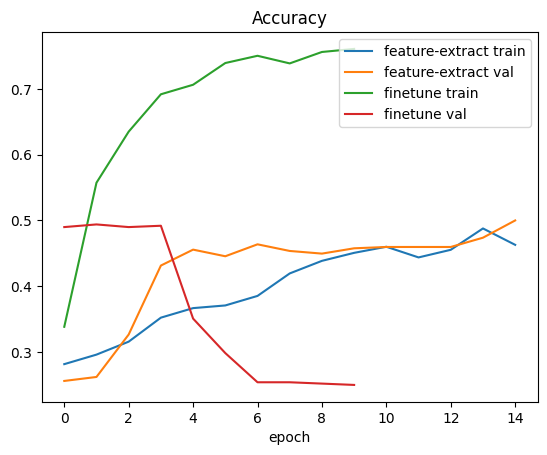

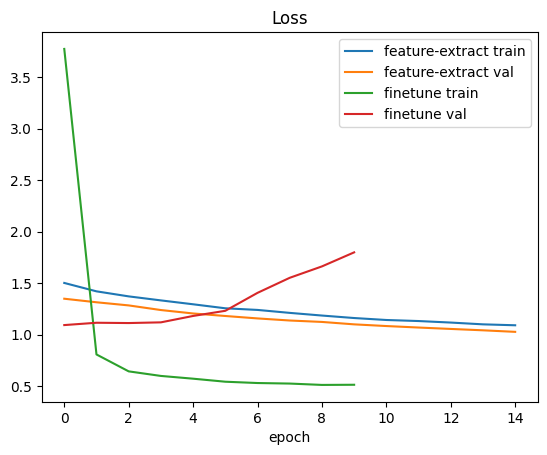

In [ ]:
def plot_curves(hists, labels):
    plt.figure();
    for h,lbl in zip(hists,labels):
        plt.plot(h.history["accuracy"], label=f"{lbl} train")
        plt.plot(h.history["val_accuracy"], label=f"{lbl} val")
    plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(); plt.show()

    plt.figure();
    for h,lbl in zip(hists,labels):
        plt.plot(h.history["loss"], label=f"{lbl} train")
        plt.plot(h.history["val_loss"], label=f"{lbl} val")
    plt.title("Loss"); plt.xlabel("epoch"); plt.legend(); plt.show()

plot_curves([history_ftx, history_ft], ["feature-extract","finetune"])


Test accuracy: 0.4939
              precision    recall  f1-score   support

 Closed_Eyes       0.00      0.00      0.00        61
   Open_Eyes       0.49      0.97      0.65        61
        Yawn       0.50      1.00      0.66        62
     No_Yawn       0.00      0.00      0.00        61

    accuracy                           0.49       245
   macro avg       0.25      0.49      0.33       245
weighted avg       0.25      0.49      0.33       245



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


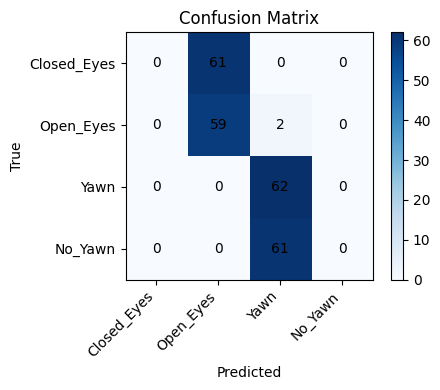

Saved report to: results/transfer_mobilenetv2_report_20251011-074101_mobilenetv2.txt


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_test, y_pred)

# Matplotlib-only confusion matrix
import numpy as np
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(num_classes)); ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticks(range(num_classes)); ax.set_yticklabels(CLASS_NAMES)
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

report_path = f"{RESULTS_DIR}/transfer_{BACKBONE}_report_{run_id}.txt"
with open(report_path, "w") as f:
    f.write(f"Test accuracy: {test_acc:.4f}\n\n")
    f.write(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
print("Saved report to:", report_path)


In [ ]:
final_path = f"{MODEL_DIR}/transfer_{BACKBONE}_final_{run_id}.keras"
model.save(final_path)
with open(f"{MODEL_DIR}/labels.json","w") as fp:
    json.dump({i:c for i,c in enumerate(CLASS_NAMES)}, fp)
print("Saved model to:", final_path)
print("Saved labels to: models/labels.json")


Saved model to: models/transfer_mobilenetv2_final_20251011-074101_mobilenetv2.keras
Saved labels to: models/labels.json


In [ ]:
import cv2
def predict_image_transfer(path, model, target_size=(224,224)):
    img = cv2.imread(path)
    if img is None: raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    x = (img/255.0).astype("float32")
    x = np.expand_dims(x, axis=0)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return {"class": CLASS_NAMES[idx], "confidence": float(probs[idx]), "probs": probs.tolist()}

# Example:
# pred = predict_image_transfer("data/sample/your_image.jpg", model, target_size=(160,160) if BACKBONE=='mobilenetv2' else (224,224))
# pred
